In [1]:
# 获取Google网盘的访问权限

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
# 参数设置

BATCH_SIZE = 10
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    
])

In [0]:
# 加载训练集与测试集

train_txt_path = './gdrive/My Drive/remote/RSDataset/train.txt'
test_txt_path = './gdrive/My Drive/remote/RSDataset/test.txt'

class MyDataset(Dataset):
    def __init__(self, txt_path, transform = None, target_transform = None):
        fh = open(txt_path, 'r')
        imgs = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0]+' '+words[1],int(words[2])))

        self.imgs = imgs        # 最主要就是要生成这个list， 然后DataLoader中给index，通过getitem读取图片数据
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = Image.open(fn).convert('RGB')     # 像素值 0~255，在transfrom.totensor会除以255，使像素值变成 0~1

        if self.transform is not None:
            img = self.transform(img)   # 在这里做transform，转为tensor等等

        return img, label

    def __len__(self):
        return len(self.imgs)
      
train_data = MyDataset(txt_path=train_txt_path, transform = transform)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data = MyDataset(txt_path=test_txt_path, transform = transform)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
# 构建CNN类

class CNN_net_1(nn.Module):
    def __init__(self):
        super(CNN_net_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(20*29*29, 1000)
        self.fc2 = nn.Linear(1000, 19)
        self.dropout=nn.Dropout()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) #10*148*148
        x = self.pool2(F.relu(self.conv2(x))) # 20*36*36
        x = x.view(-1, 20*29*29)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [0]:
# 实例化CNN模型

model = CNN_net_1().to(DEVICE)
optimizer = optim.Adam(model.parameters())

In [0]:
# 训练函数

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [0]:
# 测试函数

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target,
                                    reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

Train Epoch: 1 [90/795 (11%)]	Loss: 2.790929
Train Epoch: 1 [190/795 (24%)]	Loss: 2.992549
Train Epoch: 1 [290/795 (36%)]	Loss: 2.379081
Train Epoch: 1 [390/795 (49%)]	Loss: 2.572126
Train Epoch: 1 [490/795 (61%)]	Loss: 2.600236
Train Epoch: 1 [590/795 (74%)]	Loss: 1.850500
Train Epoch: 1 [690/795 (86%)]	Loss: 2.377918
Train Epoch: 1 [395/795 (99%)]	Loss: 2.642223

Test set: Average loss: 2.1840, Accuracy: 52/206 (25.243%)

Train Epoch: 2 [90/795 (11%)]	Loss: 2.303446
Train Epoch: 2 [190/795 (24%)]	Loss: 2.195807
Train Epoch: 2 [290/795 (36%)]	Loss: 2.248015
Train Epoch: 2 [390/795 (49%)]	Loss: 2.051998
Train Epoch: 2 [490/795 (61%)]	Loss: 1.903489
Train Epoch: 2 [590/795 (74%)]	Loss: 1.928535
Train Epoch: 2 [690/795 (86%)]	Loss: 1.345012
Train Epoch: 2 [395/795 (99%)]	Loss: 1.241487

Test set: Average loss: 2.1139, Accuracy: 65/206 (31.553%)

Train Epoch: 3 [90/795 (11%)]	Loss: 1.505259
Train Epoch: 3 [190/795 (24%)]	Loss: 2.209826
Train Epoch: 3 [290/795 (36%)]	Loss: 2.088707
Train E

Text(0.5, 1.0, 'CNN')

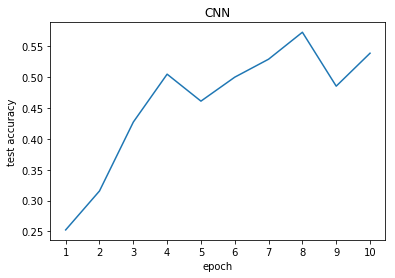

In [10]:
# 进行训练并输出结果

result = []
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    accuracy = test(model, DEVICE, test_loader)
    result.append(accuracy)

plt.plot(range(1,11),result)
plt.xticks(range(1,11))
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.title('CNN')

In [0]:
# 尝试相同深度但是卷积核数量更多的卷积网络模型

class CNN_net_2(nn.Module):
    def __init__(self):
        super(CNN_net_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 80, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(80*29*29, 2000)
        self.fc2 = nn.Linear(2000, 19)
        self.dropout=nn.Dropout()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 80*29*29)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [0]:
# 尝试层数+1的卷积网络模型

class CNN_net_3(nn.Module):
    def __init__(self):
        super(CNN_net_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(20,40,3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(40*9*9, 250)
        self.fc2 = nn.Linear(250, 19)
        self.dropout=nn.Dropout()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) 
        x = self.pool2(F.relu(self.conv2(x))) 
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 40*9*9)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [0]:
# 实例化两个新的网络结构

model_2 = CNN_net_2().to(DEVICE)
model_3 = CNN_net_3().to(DEVICE)

Train Epoch: 1 [90/795 (11%)]	Loss: 2.938951
Train Epoch: 1 [190/795 (24%)]	Loss: 2.959462
Train Epoch: 1 [290/795 (36%)]	Loss: 2.929432
Train Epoch: 1 [390/795 (49%)]	Loss: 2.950557
Train Epoch: 1 [490/795 (61%)]	Loss: 2.935597
Train Epoch: 1 [590/795 (74%)]	Loss: 2.975019
Train Epoch: 1 [690/795 (86%)]	Loss: 2.939826
Train Epoch: 1 [395/795 (99%)]	Loss: 2.976959

Test set: Average loss: 2.9425, Accuracy: 12/206 (5.825%)

Train Epoch: 2 [90/795 (11%)]	Loss: 2.942299
Train Epoch: 2 [190/795 (24%)]	Loss: 2.952573
Train Epoch: 2 [290/795 (36%)]	Loss: 2.940069
Train Epoch: 2 [390/795 (49%)]	Loss: 2.934343
Train Epoch: 2 [490/795 (61%)]	Loss: 2.933846
Train Epoch: 2 [590/795 (74%)]	Loss: 2.958867
Train Epoch: 2 [690/795 (86%)]	Loss: 2.952712
Train Epoch: 2 [395/795 (99%)]	Loss: 2.949512

Test set: Average loss: 2.9425, Accuracy: 12/206 (5.825%)

Train Epoch: 3 [90/795 (11%)]	Loss: 2.939770
Train Epoch: 3 [190/795 (24%)]	Loss: 2.936378
Train Epoch: 3 [290/795 (36%)]	Loss: 2.924908
Train Epo

Text(0.5, 1.0, 'CNN_net_2')

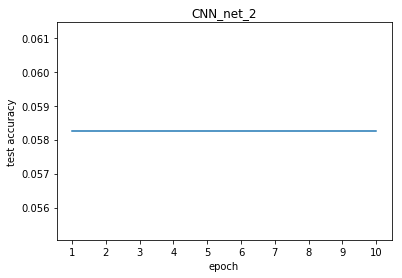

In [14]:
# 对model_2进行训练并输出结果

result = []
for epoch in range(1, EPOCHS + 1):
    train(model_2, DEVICE, train_loader, optimizer, epoch)
    accuracy = test(model_2, DEVICE, test_loader)
    result.append(accuracy)

plt.plot(range(1,EPOCHS + 1),result)
plt.xticks(range(1,EPOCHS + 1))
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.title('CNN_net_2')

Train Epoch: 1 [90/795 (11%)]	Loss: 2.950225
Train Epoch: 1 [190/795 (24%)]	Loss: 2.956111
Train Epoch: 1 [290/795 (36%)]	Loss: 2.940902
Train Epoch: 1 [390/795 (49%)]	Loss: 2.937792
Train Epoch: 1 [490/795 (61%)]	Loss: 2.946189
Train Epoch: 1 [590/795 (74%)]	Loss: 2.962553
Train Epoch: 1 [690/795 (86%)]	Loss: 2.927288
Train Epoch: 1 [395/795 (99%)]	Loss: 2.946496

Test set: Average loss: 2.9460, Accuracy: 12/206 (5.825%)

Train Epoch: 2 [90/795 (11%)]	Loss: 2.952048
Train Epoch: 2 [190/795 (24%)]	Loss: 2.949342
Train Epoch: 2 [290/795 (36%)]	Loss: 2.952216
Train Epoch: 2 [390/795 (49%)]	Loss: 2.941547
Train Epoch: 2 [490/795 (61%)]	Loss: 2.935666
Train Epoch: 2 [590/795 (74%)]	Loss: 2.932777
Train Epoch: 2 [690/795 (86%)]	Loss: 2.948546
Train Epoch: 2 [395/795 (99%)]	Loss: 2.937360

Test set: Average loss: 2.9460, Accuracy: 12/206 (5.825%)

Train Epoch: 3 [90/795 (11%)]	Loss: 2.950754
Train Epoch: 3 [190/795 (24%)]	Loss: 2.962013
Train Epoch: 3 [290/795 (36%)]	Loss: 2.943476
Train Epo

Text(0.5, 1.0, 'CNN_net_3')

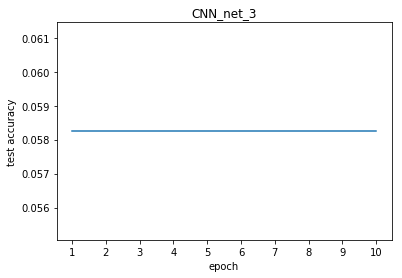

In [15]:
# 对model_2进行训练并输出结果

result = []
for epoch in range(1, EPOCHS + 1):
    train(model_3, DEVICE, train_loader, optimizer, epoch)
    accuracy = test(model_3, DEVICE, test_loader)
    result.append(accuracy)

plt.plot(range(1,EPOCHS + 1),result)
plt.xticks(range(1,EPOCHS + 1))
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.title('CNN_net_3')